In [1]:
%load_ext autoreload
%autoreload 2

In [879]:
import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

from megabouts.pipeline.full_tracking import PipelineFullTracking,PipelineFullTracking_Result
from megabouts.pipeline.cfg import ConfigTrajPreprocess,ConfigTailPreprocess,ConfigSparseCoding,ConfigTailSegmentation,ConfigClassification#ConfigTailSegmentationClassification

from megabouts.utils.utils_plot import display_trajectory
from megabouts.utils.utils import compute_outer_circle
from megabouts.utils import smallestenclosingcircle as smallestenclosingcircle


[autoreload of megabouts.preprocessing.preprocessing failed: Traceback (most recent call last):
  File "c:\Users\adrien\anaconda3\envs\ml\lib\site-packages\IPython\extensions\autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\adrien\anaconda3\envs\ml\lib\site-packages\IPython\extensions\autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "c:\Users\adrien\anaconda3\envs\ml\lib\site-packages\IPython\extensions\autoreload.py", line 377, in update_generic
    update(a, b)
  File "c:\Users\adrien\anaconda3\envs\ml\lib\site-packages\IPython\extensions\autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "c:\Users\adrien\anaconda3\envs\ml\lib\site-packages\IPython\extensions\autoreload.py", line 303, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to field '__class__'
]


# Load Sparse Code

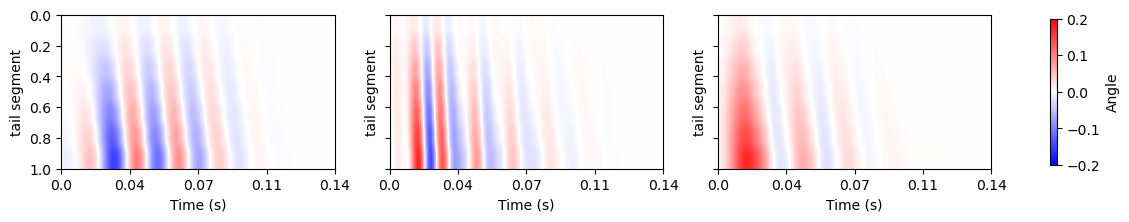

In [3]:

Dict = np.load('../megabouts/sparse_coding/3atomsDictTu.npy')

D = Dict

fig, (ax) = plt.subplots(1,3,figsize=(15,2), sharex=True,sharey=True)#,constrained_layout=True)

for i in range(D.shape[-1]):
    #ax[i].title(str(i))
    im = ax[i].imshow(D[:,:,i].T,aspect='auto',vmin=-0.2,vmax=0.2,cmap='bwr',extent=[0,100,1,0])
    ax[i].set_ylabel('tail segment')
    #ax[i,0].set_xlabel('Time (s)')
    ax[i].set_xticks(np.linspace(0,100,5))
    ax[i].set_xticklabels(np.round(np.linspace(0,100/700,5),2))

ax[0].set_xlabel('Time (s)')
ax[1].set_xlabel('Time (s)')
ax[2].set_xlabel('Time (s)')

cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
cbar.set_label('Angle')
plt.show()

# Load Data


In [4]:
df = pd.read_csv('D:\ZebrafishMatlabCSV\CatchAllBouts_atlas_20200525_1551_df.csv')
#df = df.iloc[:700*90,:]


x = df['x_blob'].values
y = df['y_blob'].values
body_angle = df['body_angle'].values
body_angle = np.arctan2(np.sin(body_angle),np.cos(body_angle))
body_angle = np.unwrap(body_angle)
# Center trajectory:
circle = compute_outer_circle(x,y)
x,y = x-circle[0],y-circle[1]

NumSegment = sum(['tail_angle' in df.columns[i] for i in range(len(df.columns))])
relative_tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,NumSegment+1)]]
relative_tail_angle = relative_tail_angle.values
tail_angle_init=np.cumsum(relative_tail_angle,1)
tail_angle = np.copy(tail_angle_init)
tail_angle[tail_angle<-10]=np.nan # Set Nan when tail angle out of range:


# Run Pipeline:

In [880]:

cfg_tail_preprocess = ConfigTailPreprocess(fps=700,num_pcs=4,limit_na_ms=100,
                                           baseline_method='slow',
                                           baseline_params={'fps':700})

cfg_traj_preprocess = ConfigTrajPreprocess(fps=700,freq_cutoff_min=10,beta=4)

cfg_sparse_coding = ConfigSparseCoding(fps=700,Dict=Dict,lmbda=0.01,gamma=0.3,mu=0.3,window_inhib_ms=85)


cfg_segment = ConfigTailSegmentation(fps=700,
                                     peak_prominence=0.4,min_code_height=1,min_spike_dist_ms=200,
                                     margin_before_peak_ms=32,bout_duration_ms=200)

cfg_classify = ConfigClassification(fps=700,
                                      margin_before_peak_ms=28,
                                      bout_duration_ms=200,
                                      augment_min_delay_ms=-4,
                                      augment_max_delay_ms=8,
                                      augment_step_delay_ms=4,
                                      feature_weight= np.array([1.6]*7+[0.5,0.4,1]),
                                      N_kNN=10
                                      )

pipeline = PipelineFullTracking(cfg_tail_preprocess,
                                cfg_traj_preprocess,
                                cfg_sparse_coding,
                                cfg_segment,
                                cfg_classify,
                                load_training=True)

(46710, 10, 170)
TimeStep:140,OriginalPeakLoc:30,TargetPeak:20
augmentation_delays:[-3  0  3]
IdSt:13
IdSt:10
IdSt:7


In [881]:
knn_training_dataset = pipeline.knn_training_dataset_augmented

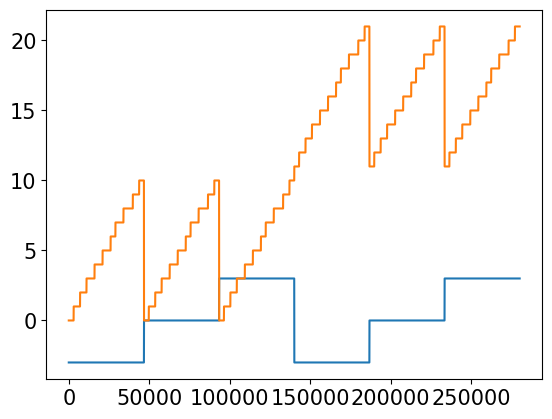

In [882]:
plt.plot(knn_training_dataset.delays)
plt.plot(knn_training_dataset.labels)

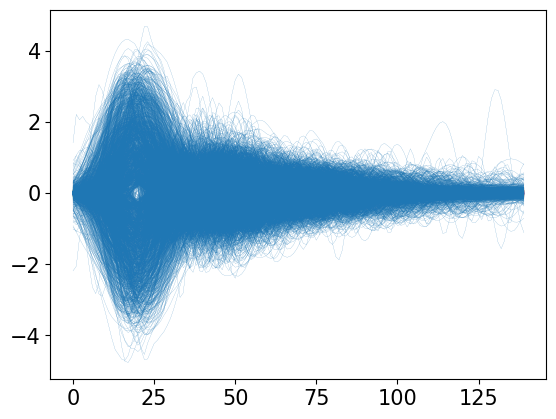

In [883]:
plt.plot(knn_training_dataset.tail[::100,-1].T,'tab:blue',lw=0.1)
plt.show()


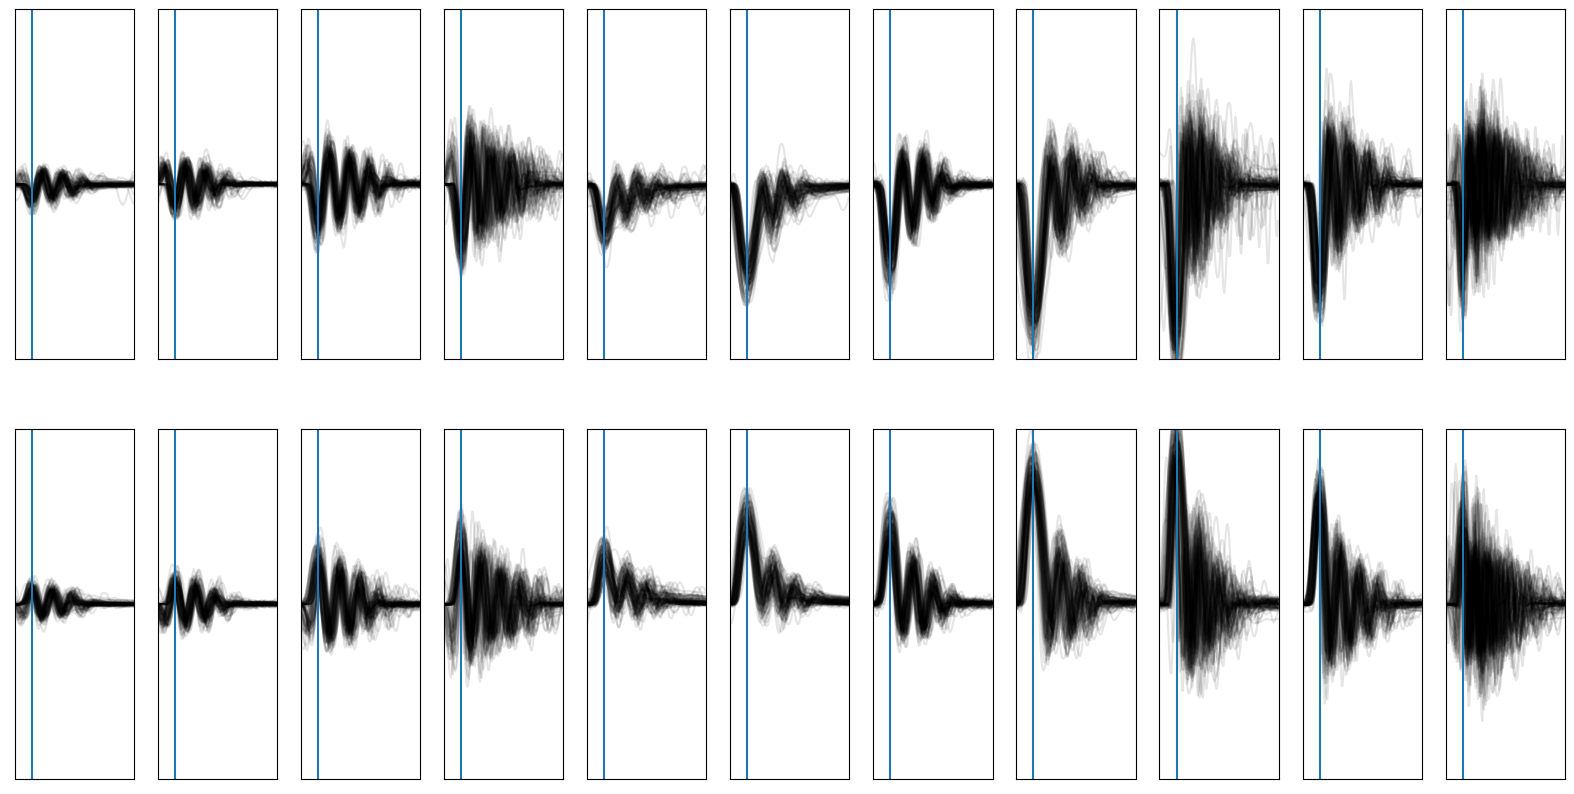

In [884]:
import matplotlib.gridspec as gridspec
from matplotlib import colors

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,11)
ax0 = {}

for k,b in enumerate(np.unique((knn_training_dataset.labels))):
    b = int(b)
    sg = 1 if b<11 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%11])    
    id = np.where(knn_training_dataset.labels==b)[0]       
    if len(id)>0:
        id = np.random.permutation(id)
        id = id[0:100]
        ax0.plot(knn_training_dataset.tail[id,-1,:].T,'k',alpha=0.1)

    ax0.vlines(20,-3.6,3.6)
    ax0.set_xlim(0,140)
    ax0.set_ylim(-3.6,3.6)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


# Import Library

In [885]:
import numpy as np
import pandas as pd
from dataclasses import dataclass,field
from functools import partial

from megabouts.pipeline.cfg import ConfigTrajPreprocess,ConfigTailPreprocess,ConfigSparseCoding,ConfigTailSegmentation,ConfigClassification

from megabouts.tracking_data.dataset import Dataset_CentroidTracking,Dataset_TailTracking,Dataset_FullTracking
from megabouts.preprocessing.preprocessing import Preprocessed_Traj
from megabouts.segmentation.segment import Segment
from megabouts.classification.template_bouts import Knn_Training_Dataset

from megabouts.preprocessing.preprocessing import preprocess_traj,preprocess_tail
from megabouts.segmentation.segment import segment_from_kinematic_activity,extract_aligned_traj,extract_bouts

from megabouts.sparse_coding.sparse_coding import compute_sparse_code,SparseCode
from megabouts.segmentation.segment import Segment,segment_from_code,segment_from_code_w_fine_alignement
from megabouts.classification.classify import bouts_classifier,Classification

from megabouts.utils.utils_bouts import compute_bout_cat_ts

# Deal with conversion of duration for good:

In [18]:
tracking_data = Dataset_FullTracking(fps=pipeline.cfg_tail_preprocess.fps,
                                     x=x,
                                     y=y,
                                     body_angle=body_angle,
                                     tail_angle=tail_angle)

clean_traj = pipeline.preprocess_traj(x=tracking_data.x,
                                      y=tracking_data.y,
                                      body_angle=tracking_data.body_angle)


tail_angle_clean,baseline = pipeline.preprocess_tail(tail_angle=tracking_data.tail_angle)
N_c = pipeline.cfg_tail_preprocess.tail_segment_cutoff
tail_angle_detrend = tail_angle_clean[:,:N_c]-baseline[:,:N_c]

tracking_data_clean = Dataset_FullTracking(fps=pipeline.cfg_tail_preprocess.fps,
                                            x=clean_traj.x,
                                            y=clean_traj.y,
                                            body_angle=clean_traj.body_angle,
                                            tail_angle=tail_angle_clean-baseline)
# Compute Sparse Code:
sparse_code = pipeline.compute_sparse_code(tail_angle_detrend)

Itn   Fnc       DFid      Regℓ1     RegLat    RegSelf   r         s         ρ       
------------------------------------------------------------------------------------
   0  1.79e+05  2.85e+04  3.71e+05  2.94e+05  1.95e+05  4.34e-01  1.59e+01  1.50e+00
   1  3.98e+05  2.11e+04  4.34e+05  7.31e+05  5.10e+05  9.57e-01  1.90e+00  1.50e+00
   2  5.57e+05  4.31e+04  4.62e+05  1.07e+06  6.25e+05  9.62e-01  7.62e-02  1.04e+00
   3  4.52e+05  7.26e+04  2.66e+05  7.63e+05  4.92e+05  6.42e-01  3.51e-01  3.58e+00
   4  4.27e+05  1.00e+05  1.98e+05  6.13e+05  4.68e+05  2.55e-01  2.85e-01  4.72e+00
   5  4.11e+05  9.54e+04  1.89e+05  5.43e+05  5.02e+05  1.78e-01  1.85e-01  4.72e+00
   6  3.94e+05  9.86e+04  1.71e+05  4.83e+05  4.97e+05  1.42e-01  1.24e-01  4.72e+00
   7  3.81e+05  1.04e+05  1.57e+05  4.27e+05  4.90e+05  1.09e-01  9.90e-02  4.72e+00
   8  3.78e+05  1.07e+05  1.52e+05  4.04e+05  4.93e+05  8.43e-02  7.20e-02  4.72e+00
   9  3.68e+05  1.07e+05  1.48e+05  3.69e+05  4.96e+05  6.64e-02 

In [1012]:

cfg_tail_preprocess = ConfigTailPreprocess(fps=700,num_pcs=4,limit_na_ms=100,
                                           baseline_method='slow',
                                           baseline_params={'fps':700})

cfg_traj_preprocess = ConfigTrajPreprocess(fps=700,freq_cutoff_min=10,beta=4)

cfg_sparse_coding = ConfigSparseCoding(fps=700,Dict=Dict,lmbda=0.01,gamma=0.3,mu=0.3,window_inhib_ms=85)

cfg_segment = ConfigTailSegmentation(fps=700,
                                     peak_prominence=0.4,min_code_height=1,min_spike_dist_ms=200,
                                     margin_before_peak_ms=40,bout_duration_ms=200)

cfg_classify = ConfigClassification(fps=700,
                                      margin_before_peak_ms=40,
                                      bout_duration_ms=200,
                                      augment_min_delay_ms=-2,
                                      augment_max_delay_ms=2,
                                      augment_step_delay_ms=2,
                                      feature_weight= np.array([1.6]*7+[0.5,0.4,1]),
                                      N_kNN=10
                                      )

pipeline = PipelineFullTracking(cfg_tail_preprocess,
                                cfg_traj_preprocess,
                                cfg_sparse_coding,
                                cfg_segment,
                                cfg_classify,

                                load_training=True)

(46710, 10, 170)
TimeStep:140,OriginalPeakLoc:30,TargetPeak:28
augmentation_delays:[-1  0]
IdSt:3
IdSt:2


In [1013]:
30*1000/700

42.857142857142854

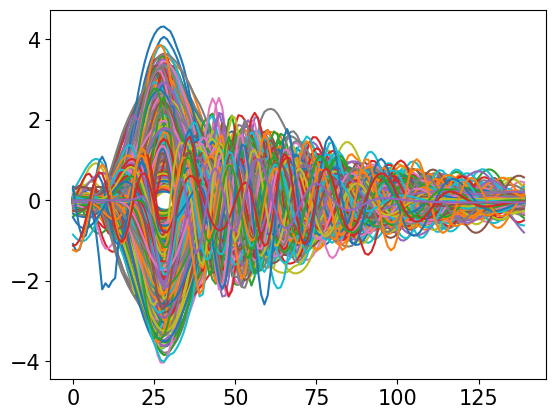

In [1014]:
bool_ = pipeline.knn_training_dataset_augmented.delays==0
plt.plot(pipeline.knn_training_dataset_augmented.tail[bool_,-1,:][::100,:].T)
plt.show()

In [1015]:
# Compute Segments:
segments,segment_original,is_aligned = pipeline.find_segment(z=sparse_code.z,tail_angle1d=tail_angle_detrend[:,N_c-1])

traj_array = extract_aligned_traj(x = clean_traj.x,
                                  y = clean_traj.y,
                                  body_angle = clean_traj.body_angle,
                                  segment = segments)

tail_array = extract_bouts(tail_angle=tail_angle_detrend,
                                segment = segments)

tail_and_traj_array = np.concatenate((tail_array,traj_array),axis=1)

classification_res = pipeline.classify(tail_and_traj_array)


In [1016]:
# Refine segmentation:
onset_shift = classification_res.onset_shift
onset_refined = [on_ + int(onset_shift[i]) for i,on_ in enumerate(segments.onset)]
offset_refined = [off_ + int(onset_shift[i]) for i,off_  in enumerate(segments.offset)]
segments_refined = Segment(onset=onset_refined,offset=offset_refined,bout_duration=pipeline.cfg_segment.bout_duration)
traj_array = extract_aligned_traj(x = clean_traj.x,
                                        y = clean_traj.y,
                                        body_angle = clean_traj.body_angle,
                                        segment = segments_refined)
tail_array = extract_bouts(tail_angle=tail_angle_detrend,
                                segment = segments_refined)
tail_and_traj_array_refined = np.concatenate((tail_array,traj_array),axis=1)

# Compute Time series of categories:
bout_category = classification_res.bout_category  
bout_category_ts,bout_category_ts_signed = compute_bout_cat_ts(segments_refined.onset,segments_refined.offset,bout_category,tracking_data.n_frames)

# Compute result:
res = PipelineFullTracking_Result(tracking_data=tracking_data,
                                        tracking_data_clean = tracking_data_clean,
                                        baseline = baseline,
                                        sparse_code = sparse_code,
                                        segments = segments_refined,
                                        segments_original = segments,
                                        tail_and_traj_array = tail_and_traj_array_refined,
                                        classification = classification_res,
                                        bout_category_ts = bout_category_ts,
                                        bout_category_ts_signed = bout_category_ts_signed)

In [1017]:
templates_labels = pipeline.knn_training_dataset_augmented.labels
tail_and_traj_array = res.tail_and_traj_array
bout_category = res.classification.bout_category
proba = res.classification.proba
outlier = res.classification.outlier_score

In [1018]:
NameCat = cfg_classify.bouts_dict['name']

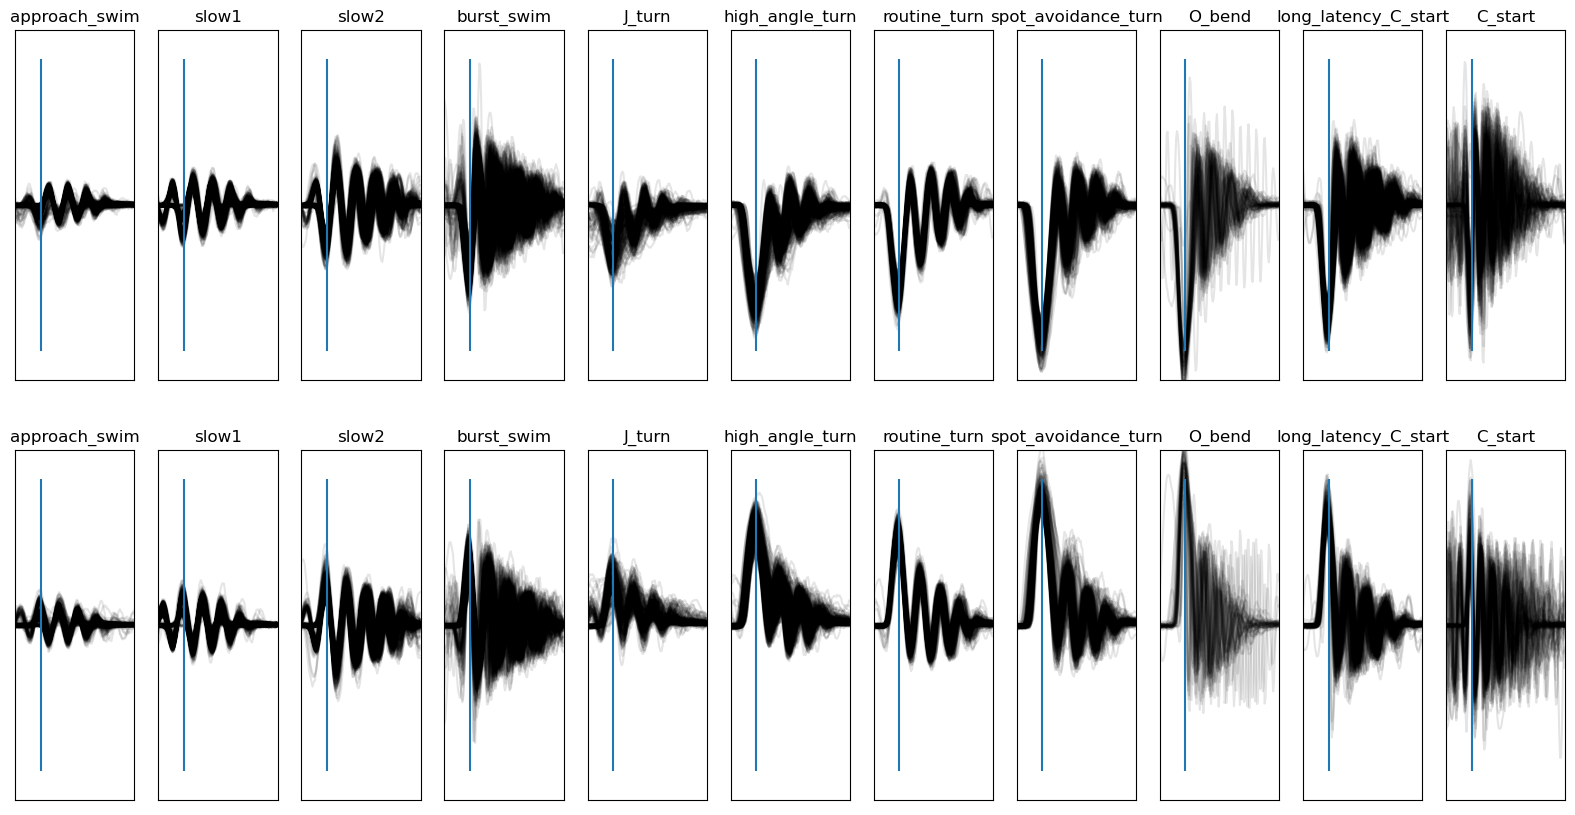

In [1020]:
fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,11)
ax0 = {}

for k,b in enumerate(np.unique((templates_labels))):
    b = int(b)
    sg = 1 if b<11 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%11])
    ax0.set_title(NameCat[b%11])
    id = np.where((bout_category==b)&(proba>0.8)&(outlier<2))[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(tail_and_traj_array[id,6,:].T,'k',alpha=0.1)

    ax0.set_xlim(0,cfg_segment.bout_duration)
    ax0.set_ylim(-3.6,3.6)
    ax0.vlines(30,-3,3)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()

# Display example results

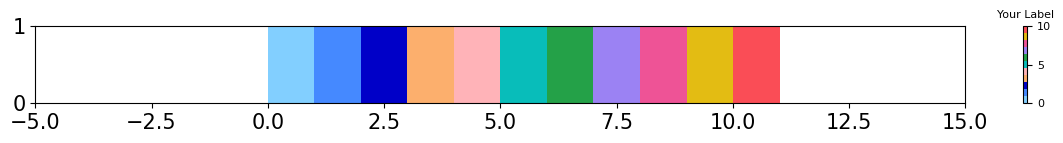

In [1021]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

color = cfg_classify.bouts_dict['color']

cmp_bouts = colors.ListedColormap(color)
cmp_bouts.set_under(color='white')
cmp_bouts.set_over(color='white')
cmp_bouts.set_bad(color='grey', alpha=None)

plt.figure(figsize=(15,1))
plt.imshow(np.arange(-5,15)[:,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=10,interpolation='nearest',extent=[-5,15,0,1])
clb=plt.colorbar()
clb.ax.tick_params(labelsize=8) 
clb.ax.set_title('Your Label',fontsize=8)
plt.show()

In [1026]:
segments = res.segments
id_nearest_template = res.classification.id_nearest_template_aligned

In [1027]:
fps = cfg_tail_preprocess.fps
Duration = fps*7
IdSt = np.random.randint(tail_angle.shape[0]-Duration)
IdEd = IdSt + Duration
t = np.linspace(0,Duration/700,Duration)

sub_onset,sub_offset,sub_i= [],[],[]
for i,(on_,off_) in enumerate(zip(segments.onset,segments.offset)):
    if (on_>IdSt)&(off_<IdEd):
        sub_onset.append(on_)
        sub_offset.append(off_)
        sub_i.append(i)
sub_i = np.array(sub_i)
sub_onset = np.array(sub_onset)
sub_offset = np.array(sub_offset)

sub_tail_array = tail_and_traj_array[sub_i,:7,:]
id = id_nearest_template[sub_i]
tail_nearest = pipeline.knn_training_dataset_augmented.tail[id,:,:]

sub_onset = sub_onset-IdSt
sub_offset = sub_offset-IdSt

(-3.6, 3.6)

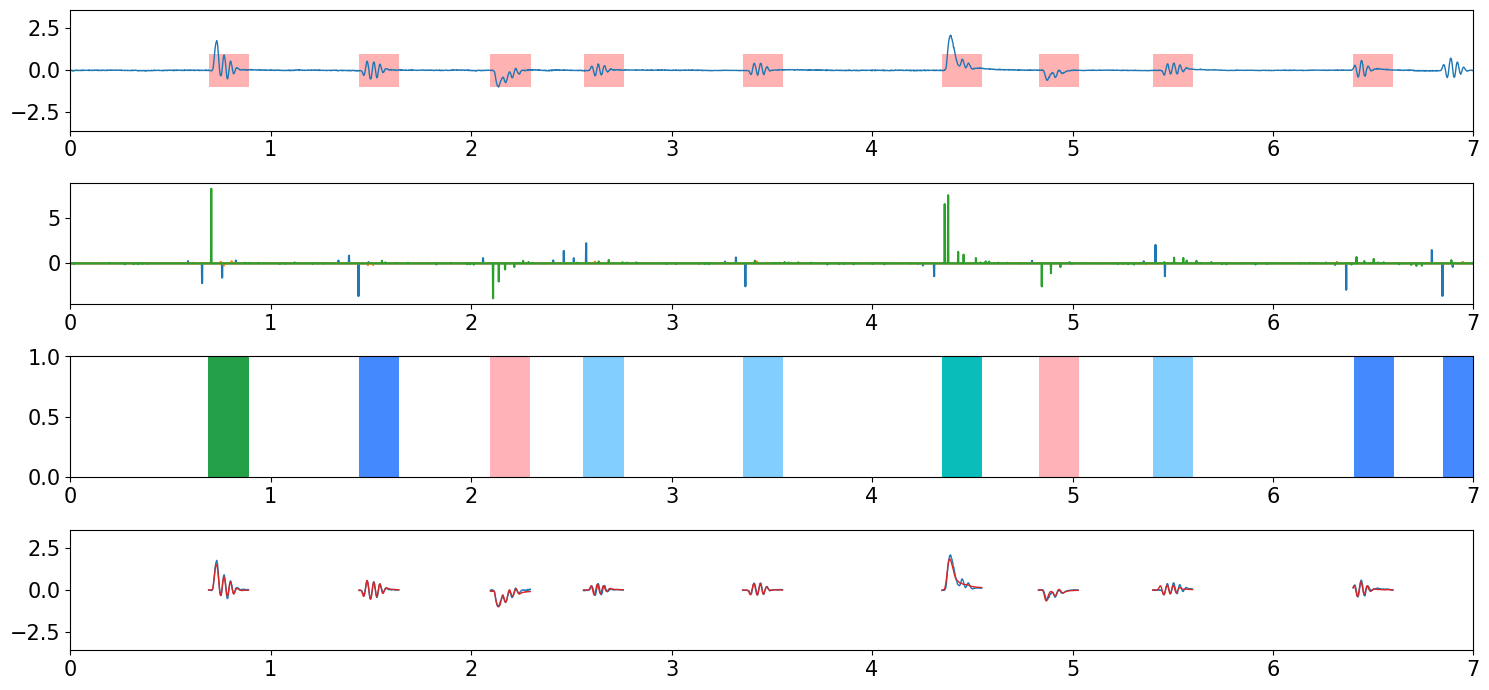

In [1028]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(facecolor='white',figsize=(15,7),tight_layout=True,sharex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(4,1)

ax = plt.subplot(G[0])
ax.plot(t,res.tracking_data_clean.tail_angle[IdSt:IdEd,6],lw=1)
#ax.plot(t,df.tail_active.values[IdSt:IdEd])
for p in sub_onset:
    ax.add_patch(Rectangle((t[p],-1),140/700,2,facecolor="red",alpha=0.3))
ax.set_xlim(0,Duration/fps)
ax.set_ylim(-3.6,3.6)
ax = plt.subplot(G[1])
ax.plot(t,res.sparse_code.z[IdSt:IdEd,:])
ax.set_xlim(0,Duration/fps)

ax = plt.subplot(G[2])
ax.imshow(res.bout_category_ts[IdSt:IdEd,np.newaxis].T,
          cmap=cmp_bouts,
          aspect='auto',
          vmin=0,vmax=10,
          interpolation='nearest',extent=[0,Duration/fps,0,1])
ax.set_xlim(0,Duration/fps)

ax = plt.subplot(G[3])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    #ax.plot((np.arange(on_,off_))/fps,tail_angle_detrend[on_+IdSt:off_+IdSt,-1],'tab:blue')
    ax.plot((np.arange(on_,off_))/fps,sub_tail_array[i,-1,:],'tab:blue',lw=1)
    #off_ = on_+140
    ax.plot((np.arange(on_,off_))/fps,tail_nearest[i,-1,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/fps)
ax.set_ylim(-3.6,3.6)


(0.0, 7.0)

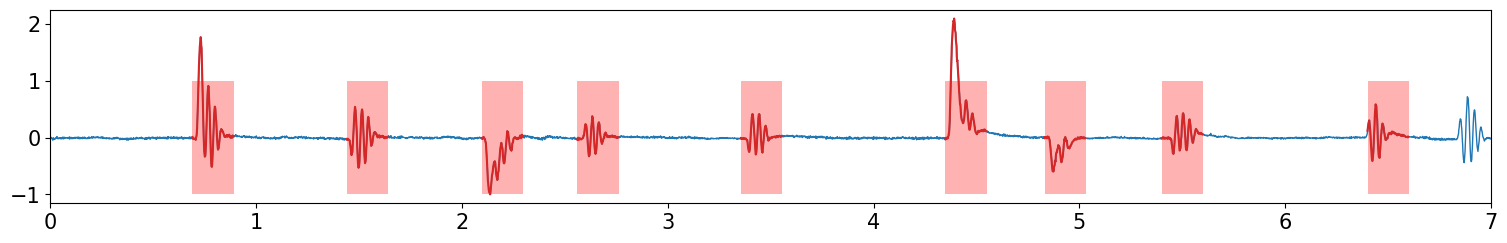

In [1029]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(facecolor='white',figsize=(15,7),tight_layout=True,sharex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(3,1)

ax = plt.subplot(G[0])
ax.plot(t,res.tracking_data_clean.tail_angle[IdSt:IdEd,6],lw=1)
#ax.plot(t,df.tail_active.values[IdSt:IdEd])
for p in sub_onset:
    ax.add_patch(Rectangle((t[p],-1),140/700,2,facecolor="red",alpha=0.3))
ax.set_xlim(0,Duration/fps)

ax = plt.subplot(G[0])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_))/fps,res.tracking_data_clean.tail_angle[on_+IdSt:off_+IdSt,6],'tab:red')
    off_ = on_+140
#ax.plot((np.arange(on_,off_))/fps,tail_nearest[i,-1,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/fps)

# Check Agreement with Matlab

In [1030]:
from megabouts.classification.benchmark_w_matlab import compute_bout_cat_matlab
from megabouts.super_resolution.downsampling import create_downsampling_function
from megabouts.utils.utils import find_onset_offset_numpy
from megabouts.utils.utils_bouts import compute_bout_cat_ts,compute_bout_cat_ts_w_CS
from scipy import stats

In [1031]:
bout_cat_matlab = df.bout_sign_matlab.values
bout_cat_matlab[df.tail_active.values==0]=-1

bout_cat_unsigned = np.copy(bout_category)
bout_cat_unsigned[bout_cat_unsigned>-1]=bout_cat_unsigned[bout_cat_unsigned>-1]%11

0 1 2 (3) (4) 5



In [1032]:
onset_mat,offset_mat,bout_cat_matlab,bout_cat_ts_matlab,bout_cat_ts_signed_matlab = compute_bout_cat_matlab(df)

label_mat = []
label_py = []
for i,(on_,off_) in enumerate(zip(onset_mat,offset_mat)):
    tmp = res.bout_category_ts[on_:off_]
    tmp = tmp[tmp>-1]
    if len(tmp)>0:
        label_mat.append(bout_cat_matlab[i])
        val_py = stats.mode(tmp)[0][0]
        if val_py>2:
            val_py = val_py+2
        label_py.append(val_py)


C:\Users\adrien\AppData\Local\Temp\ipykernel_42808\168942732.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  val_py = stats.mode(tmp)[0][0]


In [1033]:
np.unique(res.classification.bout_category)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21], dtype=int64)

In [1034]:
x = np.array(label_mat)
y = np.array(label_py)
# Accuracy:
x_noCS = x[(x!=3)&(x!=4)]
y_noCS = y[(x!=3)&(x!=4)]

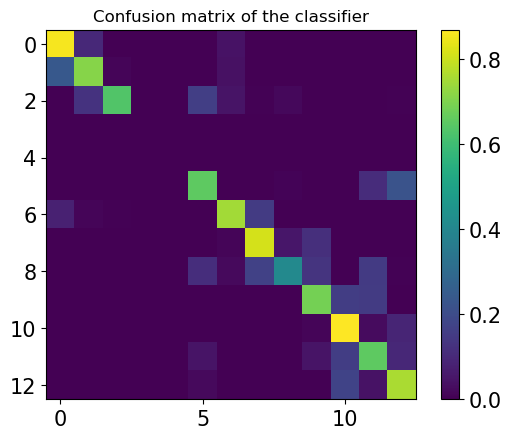

In [1035]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(x_noCS, y_noCS, labels = np.arange(13),normalize='true')#{‘true’, ‘pred’, ‘all’,'none})
plt.imshow(cm)
plt.title('Confusion matrix of the classifier')
plt.colorbar()
#plt.xticks(np.arange(13),NameCat[0:13],rotation=90)
#plt.yticks(np.arange(13),NameCat[0:13],rotation=0)
plt.show()

In [1036]:
x.shape,proba.shape,y.shape

((14246,), (14324,), (14246,))

In [1037]:
from sklearn.metrics import f1_score
f1_score(x_noCS, y_noCS, average='macro')

0.5415533959883022

In [1038]:
from sklearn.metrics import accuracy_score
accuracy_score(x_noCS, y_noCS)

0.6370230211289813

In [1039]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(x_noCS, y_noCS)

0.7095172205310146

# Basic + Hard benchmarking: avoid double bouts + Make sure the onset are aligned + Make sure proba is high

In [1040]:
bout_cat_matlab = df.bout_sign_matlab.values
bout_cat_matlab[df.tail_active.values==0]=-1

bout_cat_unsigned = np.copy(bout_category)
bout_cat_unsigned[bout_cat_unsigned>-1]=bout_cat_unsigned[bout_cat_unsigned>-1]%11

In [1041]:
onset_mat,offset_mat,bout_cat_matlab,bout_cat_ts_matlab,bout_cat_ts_signed_matlab = compute_bout_cat_matlab(df)


In [1042]:
np.unique(bout_cat_matlab),np.unique(res.classification.bout_category)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21], dtype=int64))

In [1043]:
seg_py = res.segments

In [1044]:
proba.shape,outlier.shape,len(seg_py.onset)

((14324,), (14324,), 14324)

In [1069]:
label_mat = []
label_py = []
id_py = []
dist = np.zeros(len(seg_py.onset))

for i,(on_,off_,bout_py) in enumerate(zip(seg_py.onset,seg_py.offset,res.classification.bout_category)):
        
    id = np.argmin(np.abs(on_-onset_mat))
    d_ = on_-onset_mat[id]
    
    bout_m = int(bout_cat_matlab[id])
    accept_bouts_mat = (bout_m!=3)&(bout_m!=4)
    if bout_m>3:
        bout_m = bout_m-2
    bout_py = int(bout_py%11)

    accept_delay = (d_>-20)&(d_<20)
    dist[i] = d_

    if i>0:
        accept_delay = accept_delay&((on_-seg_py.offset[i-1])>400)

    accept_bouts_py = (proba[i]>0.9)&(outlier[i]<1.2)
    
    if accept_delay&accept_bouts_mat&accept_bouts_py:
        label_mat.append(bout_m)
        label_py.append(bout_py)
        id_py.append(i)

        

In [1070]:
len(label_mat)/len(seg_py.onset)

0.1744624406590338

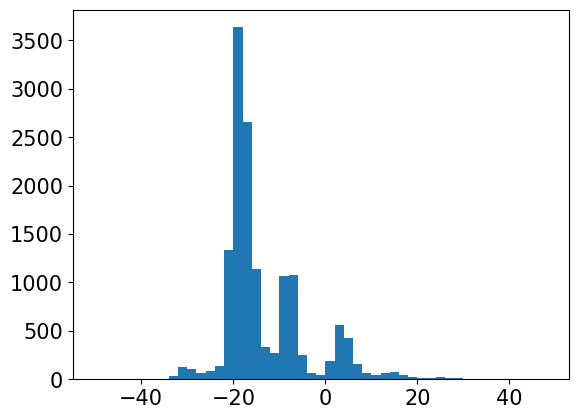

In [1071]:
plt.hist(dist,np.arange(-50,50,2))
plt.show()

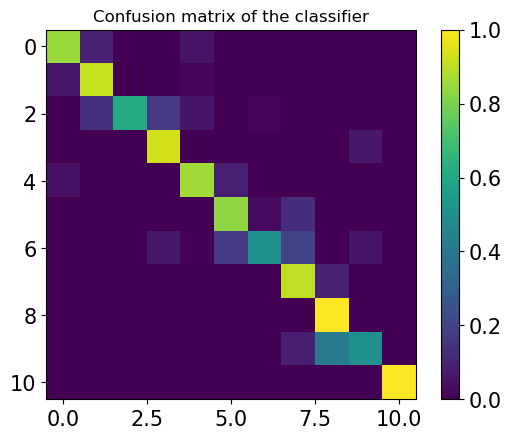

In [1072]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label_mat, label_py, labels = np.arange(11),normalize='true')#{‘true’, ‘pred’, ‘all’,'none})
plt.imshow(cm)
plt.title('Confusion matrix of the classifier')
plt.colorbar()
#plt.xticks(np.arange(13),NameCat[0:13],rotation=90)
#plt.yticks(np.arange(13),NameCat[0:13],rotation=0)
plt.show()

In [1073]:
from sklearn.metrics import accuracy_score
accuracy_score(label_mat, label_py)

0.6858743497398959

In [1074]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(label_mat, label_py)

0.8109060642945416

In [1075]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(label_py, label_mat)

0.5849882517483974

# Display Error Per Categories:

In [1076]:
np.unique(label_mat)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [1077]:
b = 5
sg = 2*(bout_category[id_py]>10)-1
Xflat_ = np.reshape(tail_and_traj_array[id_py,:],(-1,10*140))
id_bad = np.where((np.array(label_mat)==b)&(np.array(label_py)!=b))[0]
id_good = np.where((np.array(label_mat)==b)&(np.array(label_py)==b))[0]
print(len(id_good),len(id_bad))
id_n = id_nearest_template[id_py]
X_nearest = pipeline.knn_training_dataset_augmented.tail_and_traj_flat[id_n,:]


309 61


1960
5
5


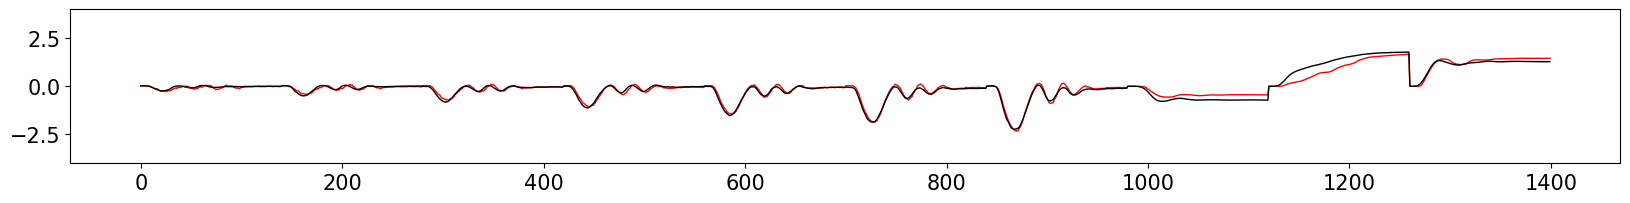

5
7


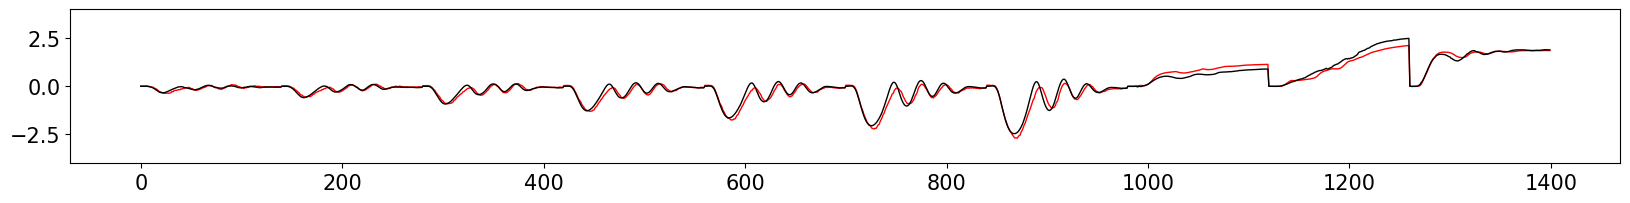

In [1078]:
plt.figure(figsize=(20,2))
i = np.random.choice(id_good)
print(i)
print(label_mat[i])
print(label_py[i])
plt.plot(sg[i]*Xflat_[i,:].T,'r',lw=1)
plt.plot(sg[i]*X_nearest[i,:].T,'k',lw=1)
plt.ylim(-4,4)
plt.show()
plt.figure(figsize=(20,2))
i = np.random.choice(id_bad)
print(label_mat[i])
print(label_py[i])
plt.plot(sg[i]*Xflat_[i,:].T,'r',lw=1)
plt.plot(sg[i]*X_nearest[i,:].T,'k',lw=1)
plt.ylim(-4,4)
plt.show()

# Are the error similarly close in training set

In [854]:
templates_labels[id_n][i]

21

In [824]:
templates_labels[id_n].shape

(5964,)

In [825]:
len(label_mat)

5964

In [877]:
len(id_py)

5964

In [878]:
np.unique(templates_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

0

In [731]:
pipeline.knn_training_dataset_augmented.tail.shape

(264000, 7, 140)

In [706]:
len(id_nearest_template)

14324

In [ ]:
sub_tail_array = tail_and_traj_array[sub_i,:7,:]

sub_onset = sub_onset-IdSt
sub_offset = sub_offset-IdSt

In [ ]:
0.70, margin_before_peak_ms=32,augment_max_delay_ms=18,N_kNN=10,filename_template='TemplateFromkNN_Tu.npz'

0.69, margin_before_peak_ms=32,augment_max_delay_ms=18,N_kNN=3,filename_template='TemplateFromkNN_Tu.npz'

0.717 margin_before_peak_ms=32,augment_max_delay_ms=18,N_kNN=10,filename_template='kNN_Training_Dataset.npz'
                                                            


In [ ]:
0.7110439583131611 knn=3

# Display Time Series

# Plotly Save

In [34]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px


In [35]:
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale


In [36]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

cmp_bouts = colors.ListedColormap(['#FFFFFF'] + list_color_w_CS)


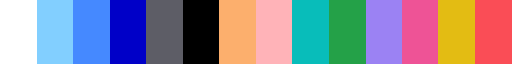

In [37]:
cmp_bouts

In [41]:
img.shape,np.unique(img)

((1, 40),
 array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29]))

In [35]:
import plotly.express as px
import numpy as np

img = np.arange(-10,30).reshape(1,-1)
fig = px.imshow(img,color_continuous_scale=cmp_bouts,zmin=-1,zmax=13)

#fig.write_html("free_swimming_pipeline.html")

[autoreload of preprocessing.preprocessing failed: Traceback (most recent call last):
  File "C:\Users\adrien\AppData\Roaming\Python\Python38\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\adrien\AppData\Roaming\Python\Python38\site-packages\IPython\extensions\autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\adrien\AppData\Roaming\Python\Python38\site-packages\IPython\extensions\autoreload.py", line 347, in update_generic
    update(a, b)
  File "C:\Users\adrien\AppData\Roaming\Python\Python38\site-packages\IPython\extensions\autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "C:\Users\adrien\AppData\Roaming\Python\Python38\site-packages\IPython\extensions\autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to field '__class_

NameError: name 'cmp_bouts' is not defined

In [38]:
s = 7
onset,offset = segments.onset,segments.offset
x = tail_angle_clean[:,s][:,np.newaxis]
y = np.zeros_like(x)
for on_,off_ in zip(onset,offset):
    y[on_:off_]=1
t = np.arange(len(x))[:,np.newaxis]

print(x.shape,y.shape,t.shape,z.shape)
df=pd.DataFrame(np.hstack((t,x,y,z)), columns=['t','tail','tail_active','code1','code2','code3'])
id_st = 700*60*0
id_ed = 700*60*20
df = df.iloc[id_st:id_ed]
sub_onset,sub_offset=[],[]

for on_,off_ in zip(onset,offset):
    if (on_>id_st)&(off_<id_ed):
        sub_onset.append(on_)
        sub_offset.append(off_)

(8908250, 1) (8908250, 1) (8908250, 1) (8908250, 3)


In [39]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True)

fig.add_trace(go.Scatter(x=df['t'], y=df['tail'],mode='lines'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df['t'], y=df['tail_active'],mode='lines'),
              row=1, col=1)


for i,(on_,off_) in enumerate(zip(sub_onset[:200],sub_offset[:200])):
    if i%2==0:
        fig.add_vrect(x0=on_, x1=off_,line_width=0,fillcolor='#EDAE49',opacity=0.3,layer="below")
    else:
        fig.add_vrect(x0=on_, x1=off_,line_width=0,fillcolor='#D1495B',opacity=0.3,layer="below")

#fig.add_trace(go.Scatter(x=peaks, y=np.ones(len(peaks)),mode='markers'),
#              row=1, col=1)
fig.add_trace(go.Scatter(x=df['t'], y=df['code1'],mode='lines'),
              row=2, col=1)   
fig.add_trace(go.Scatter(x=df['t'], y=df['code2'],mode='lines'),
              row=2, col=1)   
fig.add_trace(go.Scatter(x=df['t'], y=df['code3'],mode='lines'),
              row=2, col=1)   

#fig['layout']['yaxis2'].update(title='', range=[0, 40], dtick=10, autorange=False)
#fig['layout']['yaxis1'].update(title='', range=[-3,3], dtick=10, autorange=False)

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.write_html("free_swimming_pipeline.html")


NameError: name 'make_subplots' is not defined

# Illustration of sparse coding

[0 1 2]


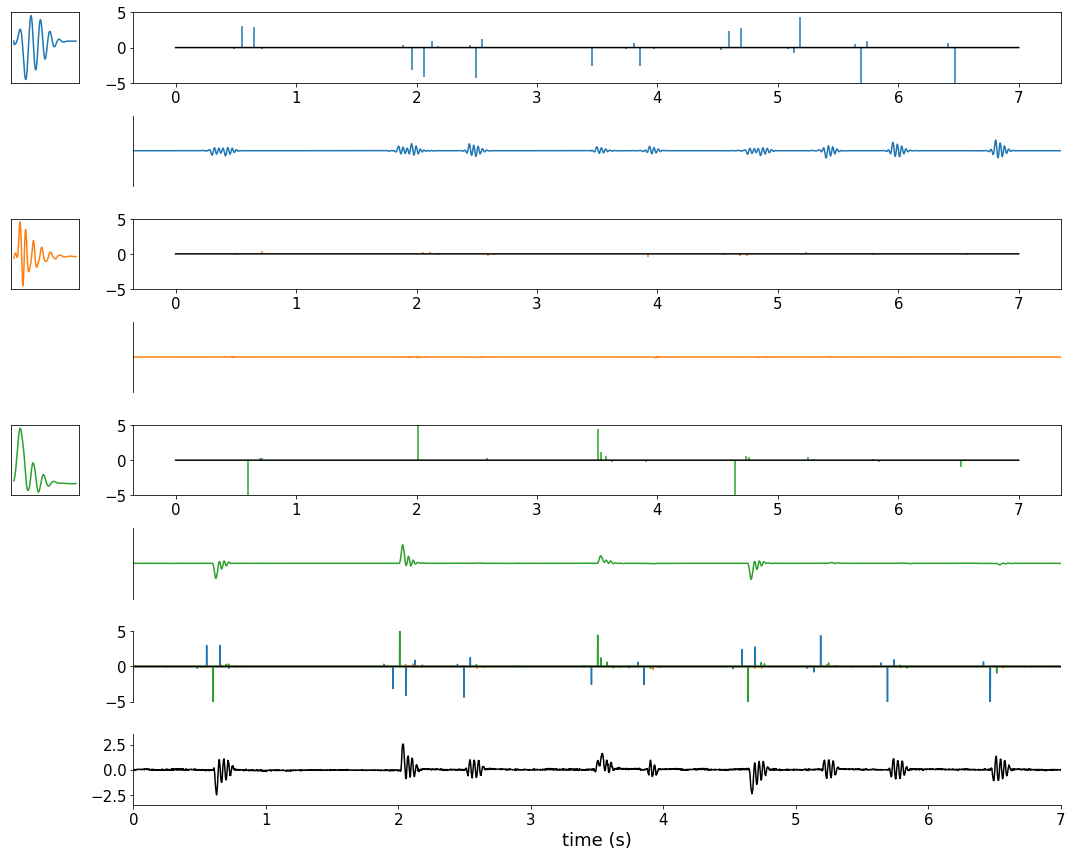

In [45]:
code = np.copy(z)
t = np.arange(0,Duration)/700
id_atom = np.where(np.sum(np.abs(code[IdSt:IdEd,:]),axis=0)>5)[0]

#id_atom = [i for i in ordered_atom if np.any(np.isin(id_atom,i))]
print(id_atom)
N = len(id_atom)
cmap = plt.cm.tab10  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

fig, ax = plt.subplots(facecolor='white',figsize=(15,12),tight_layout=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(2*N+2,9)

ax = plt.subplot(G[-1:,1:])
ax.plot(t,tail_angle[IdSt:IdEd,7],'k')
ax.set_ylim(-3.5,3.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0,Duration/700)
ax.set_xlabel('time (s)',fontdict={'fontsize':18})
#ax.set_ylabel('tail angle \n (rad)',fontdict={'fontsize':18},rotation='horizontal')

ax = plt.subplot(G[-2,1:])
for i,i_code in enumerate(id_atom):
    ax.plot(t,code[IdSt:IdEd,i_code],color=cmaplist[i])
ax.plot(t,code[IdSt:IdEd,i_code]*0,color='k')
ax.set_xticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim(0,Duration/700)
ax.set_ylim(-5,5)
#ax.set_ylabel('sparse code',fontdict={'fontsize':18},rotation='horizontal')

# ax.set_ylim(-3,3)
markerline = {}
stemline = {}
k=0
for i,i_code in enumerate(id_atom):
    ax = plt.subplot(G[k,1:])
    ax.plot(t,code[IdSt:IdEd,i_code]*0,color='k')
    y = code[IdSt:IdEd,i_code]
    x = t
    x = x[np.abs(y)>0.1]
    y = y[np.abs(y)>0.1]

    if len(x)>0:
        markerline[i], stemline[i], baseline = ax.stem(x,y,use_line_collection=True)
        baseline.remove()
        markerline[i].remove()
        #plt.setp(markerline[i], color=cmaplist[i]) 
        plt.setp(stemline[i], color=cmaplist[i])
    ax.set_ylim(-5,5)

    
    ax = plt.subplot(G[k+1,1:])
    ax.plot(t,decomposition[IdSt:IdEd,i_code],color=cmaplist[i])
        
    ax.set_ylim(-3.5,3.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlim(0,Duration/700)

    ax = plt.subplot(G[k:k+1,0])
    ax.plot(Dict[:,-1,i_code],color=cmaplist[i])
    ax.set_xticks([])
    ax.set_yticks([])

    k=k+2


#plt.savefig('SparseCoding_'+strain+'.png',dpi=300, bbox_inches = "tight")

plt.show()